### IDs:
Insert yours IDs to the cell below

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. You are free to add cells.
1. Write your functions and your answers in this jupyter notebook only.
1. Answers to theoretical questions should be written in **markdown cells (with $\LaTeX$ support)**.
1. Submit this jupyter notebook only using your ID as a filename. Not to use ZIP or RAR. For example, your Moodle submission file name should look like this (two id numbers): `123456789_987654321.ipynb`.

In [1]:
import os

In [2]:
import numpy as np
from numpy import sum 
import matplotlib.pyplot as plt 
import scipy.stats
import math
from scipy.stats import geom, norm
from sympy import symbols, pi, exp, solve, Eq
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.mixture import GaussianMixture
import seaborn as sns
from tabulate import tabulate
import matplotlib.gridspec as gridspec
sns.set(rc={'figure.figsize':(10,5)})
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0)

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
class PlotMover:
    # based on SeabornFig2Grid
    def __init__(self, joint_plot, target_fig, subplot_loc):
        self.joint_plot = joint_plot
        self.target_fig = target_fig
        self.subplot_loc = subplot_loc
        self._move_plot()
        self._cleanup_figure()
    
    def _move_plot(self):
        joint_height = self.joint_plot.ax_joint.get_position().height
        marg_x_height = self.joint_plot.ax_marg_x.get_position().height
        num_rows = int(np.round(joint_height / marg_x_height))
        self._resize_plot()
        subplot_grid = gridspec.GridSpecFromSubplotSpec(num_rows+1, num_rows+1, subplot_spec=self.subplot_loc)
        self._move_subplot(self.joint_plot.ax_joint, subplot_grid[1:, :-1])
        self._move_subplot(self.joint_plot.ax_marg_x, subplot_grid[0, :-1])
        self._move_subplot(self.joint_plot.ax_marg_y, subplot_grid[1:, -1])
    
    def _move_subplot(self, subplot, subplot_grid_loc):
        subplot.remove()
        subplot.figure = self.target_fig
        self.target_fig.axes.append(subplot)
        self.target_fig.add_axes(subplot)
        subplot._subplotspec = subplot_grid_loc
        subplot.set_position(subplot_grid_loc.get_position(self.target_fig))
        subplot.set_subplotspec(subplot_grid_loc)
    
    def _cleanup_figure(self):
        plt.close(self.joint_plot.fig)
        self.target_fig.canvas.mpl_connect("resize_event", lambda evt: self._resize_plot())
        self.target_fig.canvas.draw()
    
    def _resize_plot(self):
        self.joint_plot.fig.set_size_inches(self.target_fig.get_size_inches())

### Question 1 - Data exploration and visialization - practical

Load Boston dataset from sklearn.
Explore the data. follow th instructions below and make sure to support your answers with proper outputs and plots.
When plotting, pay close attention to the range of the axis, and include axis labels and a title for the figure.

1. Describe the dataset. How many samples does it contain? How many features? What isis the data type for each variable?
2. Produce a histogram and a boxplot of the nitric oxides concentration. describe the distribution.
3. Produce a correlation matrix of all the features. Are there any correlated features? Can you identify one feature with unusual behaviour?
4. Select the 2 pairs of features with the highest correlation (positive or negative) and plot 2 scatter plots with marginal histograms (JointPlot). 
5. Produce a cumulative histogram of the age variable and add two horizontal lines on the first and third quartile (on the cumulative count)
6. Identify and report 2 “interesting” trends in the data. No need to provide statistical confidence at this point. 

We load the dataset, but it has ethical issues...

In [4]:
dataset = load_boston()

Describe the dataset. How many samples does it contain? How many features? What is the data type for each variable?

In [5]:
print(dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df = pd.DataFrame(dataset.data, columns = dataset.feature_names)

In [7]:
df.CHAS = pd.Series(np.where(df.CHAS == 1, "River","No_River"), dtype='category')

<div class="alert alert-info">
This dataset contains 506 rows (instances) and 13 columns (features). The variables are numeric except for the proximity to Charles river, which was a dummy variable representinf a two level factor. We converted that variable back to categorical representation for now...
</div>

Produce a histogram and a boxplot of the nitric oxides concentration. describe the distribution.

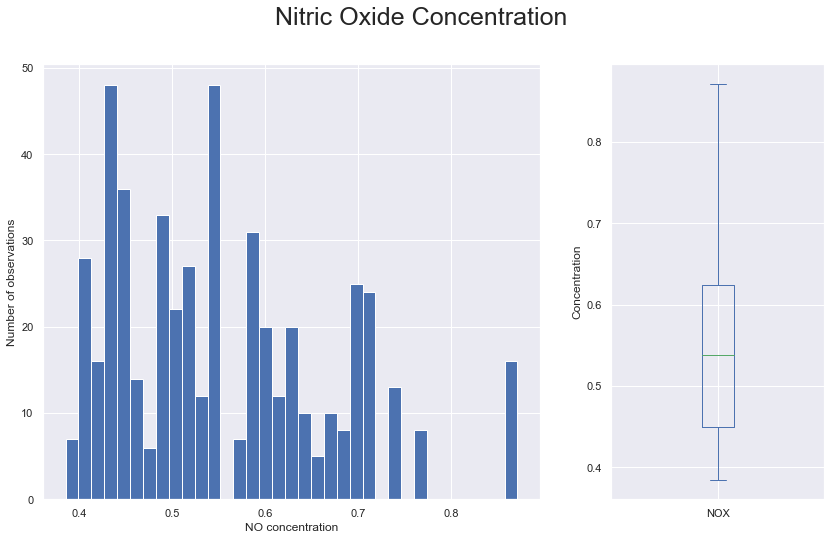

In [8]:
figure, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": (.7, .3)})
ax0 = df['NOX'].hist(bins=35, ax=axes[0])
ax1 = df['NOX'].plot.box(ax=axes[1])

figure.suptitle('Nitric Oxide Concentration', fontsize=25)
ax0.set_ylabel("Number of observations")
ax0.set_xlabel("NO concentration")
ax1.set_ylabel("Concentration");

<div class="alert alert-info">
We have a distribution in the histogram which appears to have a longer right tail with the amount of houses on the right side becoming smaller, with the majority on the left, near where the highest concentrarion of Nitric Oxide (an indicator for air quality indoors) is present (between 0.4 and 0.6). So we can see that at lower nitric oxide concentration there are more houses. The box plot confirms our visual analysis, as it represents 50% of the values and the range is roughly between 0.4 and 0.6, and the median is at around .54.
</div>

Produce a correlation matrix of all the features. Are there any correlated features? Can you identify one feature with unusual behaviour?

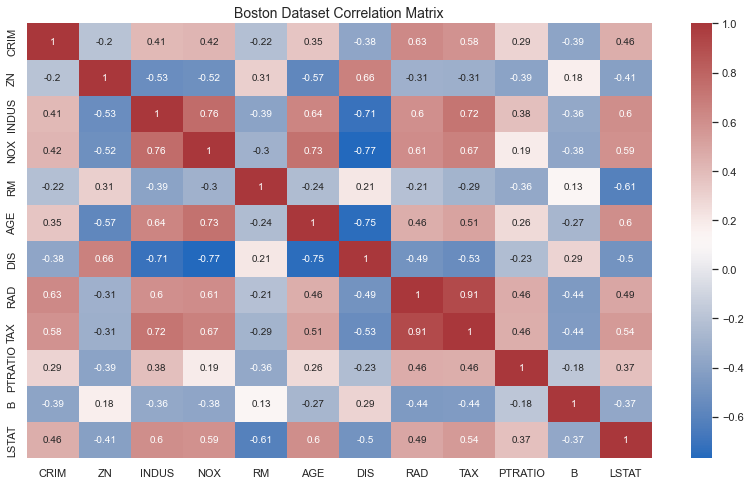

In [9]:
sns.heatmap(df.corr(), annot=True, cmap= "vlag")
plt.title("Boston Dataset Correlation Matrix", size =14);

<div class="alert alert-info">
When variable CHAS (proximity to river) was represented as a dummy (0 or 1 numeric values), it stood out by having very little, if any, correlation with any other variable in the dataset. With CHAS converted back to categorical representation, it is now not shown in the correlation matrix. From the correlation matrix, we can also that there are some features that are highly correlated with each other. For example, RAD and TAX and NOX and INDUS.

There are also some features that have a negative correlation with other features. For example, the NOX and DIS features have a correlation coefficient of -0.77, which indicates a strong negative correlation.
</div>

Select the 2 pairs of features with the highest correlation (positive or negative) and plot 2 scatter plots with marginal histograms (JointPlot).

<div class="alert alert-info">
We create the table of correlations because it is easier to see, let's take a look at few strongest correlations (sorted by by absolute value!)
</div>

In [10]:
correlation_table = (df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(bool)).stack().sort_values(ascending=False, key=np.abs))
print(tabulate(pd.DataFrame(correlation_table).iloc[0:5,], headers=['Feature Pair', 'Correlation'], tablefmt='grid'))

+------------------+---------------+
| Feature Pair     |   Correlation |
+==================+===============+
| ('RAD', 'TAX')   |      0.910228 |
+------------------+---------------+
| ('NOX', 'DIS')   |     -0.76923  |
+------------------+---------------+
| ('INDUS', 'NOX') |      0.763651 |
+------------------+---------------+
| ('AGE', 'DIS')   |     -0.747881 |
+------------------+---------------+
| ('NOX', 'AGE')   |      0.73147  |
+------------------+---------------+


<div class="alert alert-info">
From the table, we select the pair with the highest absolute correlation (which happens to be positive), RAD and TAX, and the pair with the next-largest absolute correlation (happens to be negative), NOX and DIS.
    
We can explain these relationships as follows: RAD is the index of accessibility to radial highways and TAX is the full-value property-tax rate per $10,000. This relationship shows that housing that has greater access to transportation is taxed more highly. While this is in general true, living next to a highway and noisy streets in Boston is unpleasant. NOX is the nitric oxides concentration (parts per 10 million) and DIS is the weighted distances to five Boston employment centres. This relationship demonstrates what we may know according to general knowledge: a city center is more polluted, with more cars, more dense housing and more employment centers, and the air quality in these areas is much worse than in neighborhoods.
    
</div>

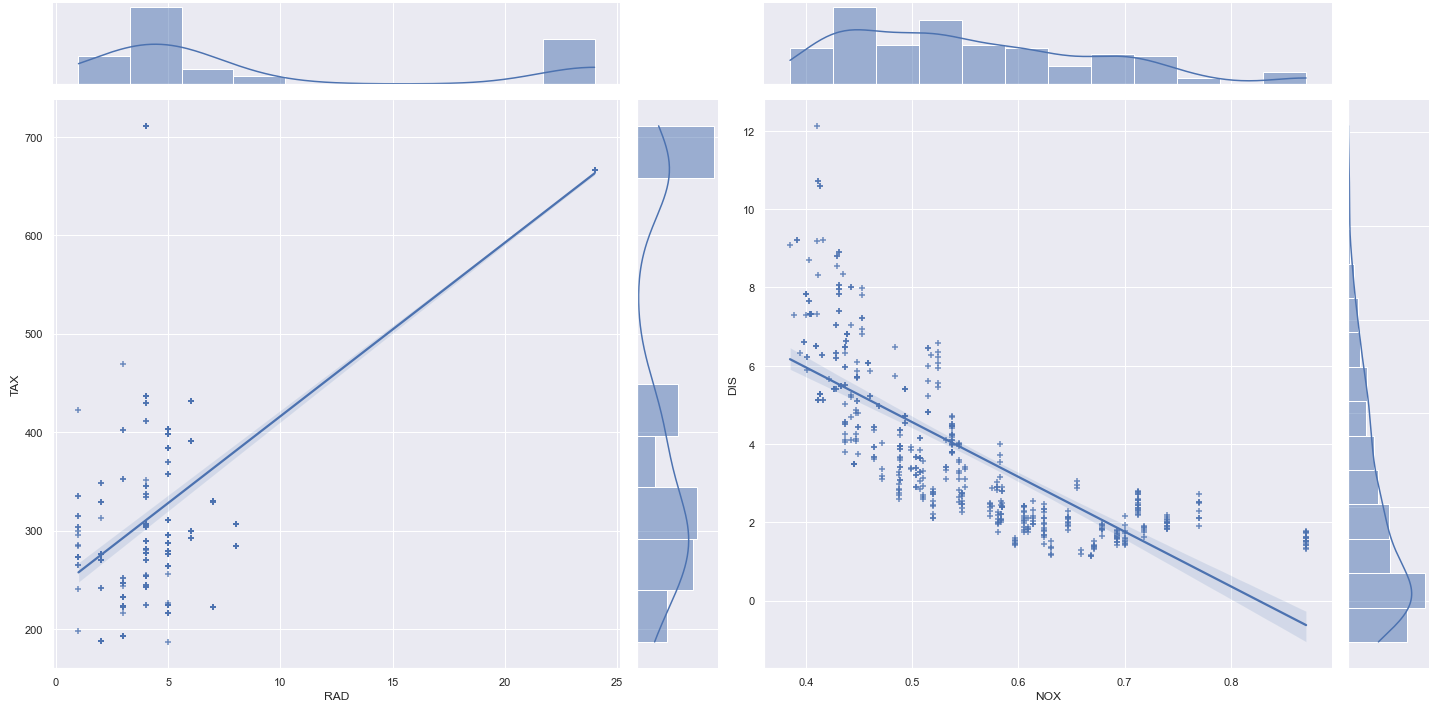

In [11]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2)

ax0 = PlotMover(sns.jointplot(data=df, x='RAD', y='TAX', kind='reg', marker='+'), fig, gs[0])
ax1 = PlotMover(sns.jointplot(data=df, x='NOX', y='DIS', kind='reg', marker='+'), fig, gs[1])

gs.tight_layout(fig)
plt.show()

Produce a cumulative histogram of the age variable and add two horizontal lines on the first and third quartile (on the cumulative count)

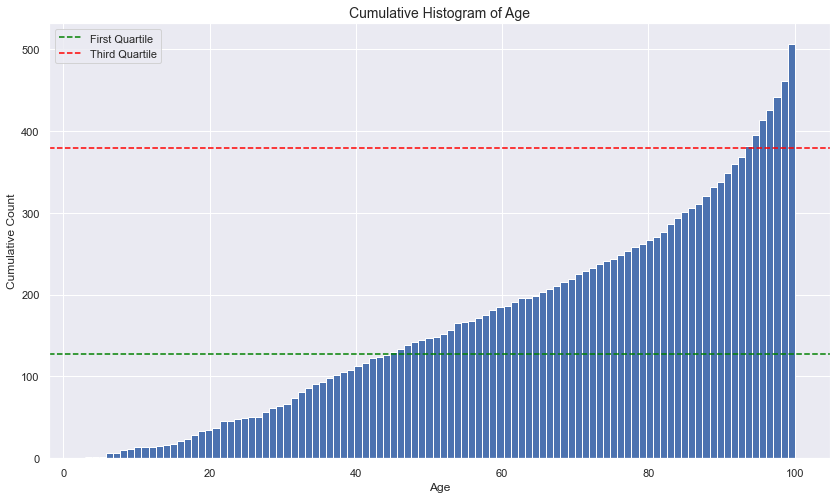

In [12]:
plt.title("Cumulative Histogram of Age", size=14)
plt.hist(df['AGE'], cumulative = True, bins=100)
plt.axhline(len(df['AGE'][df['AGE'] < df['AGE'].quantile(.25)]), color='green', linestyle='dashed', label='First Quartile')
plt.axhline(len(df['AGE'][df['AGE'] < df['AGE'].quantile(.75)]), color='red', linestyle='dashed',label='Third Quartile')
plt.xlabel("Age")
plt.ylabel("Cumulative Count")
plt.legend()
plt.plot();

Identify and report 2 “interesting” trends in the data. No need to provide statistical confidence at this point

<div class="alert alert-info">
AGE and NOX is positively correlated and makes sense since unless highly renovated and up to norm, older buildings usually have worse insulation and airflow which can lead to the accumulation of nitric oxide. Older building are usually in city centers where it is more polluted.

DIS and AGE are negatively correlated which makes also sense since older building are usually loacted in city centers and therefore are closer to employment centers which should be located in areas where employment demand is high.
</div>

### Question 2 - Independence and conditional independence

#### 2.A
Let $\ X, Y \ $ and $Z$  be discrete random variables with $\ n, m \ $ and $k=4$ possible outcomes respectivley.

How many parameters define the joint distribution of $\ X, Y \ $ and $Z$?

<div class="alert alert-info">
    
In general, we need to specify each possible combination of variables (less one, as the probability distribution should sum to 1), so we get $(n \cdot m \cdot k) - 1$. If in this case $k=4$ then $ 4 n  m  - 1$ 
</div>

#### 2.B
For the same random variables from the previous section, how many parameters define the joint distribution of $\ X, Y \ $ and $Z$ if we now know that they are independent?

<div class="alert alert-info">
    
Independence is defined as $P(X=x, Y=y, Z=z)=P(X=x)\cdot P(Y=y) \cdot P(Z=z)$.
    
Unless we have some special form of parametrized distribution (for instance Binomial($p$, $N$) which is parametrized by two parameters (the success probability and the total number of trials), in most general case to specify the probability distribution of a discrete random variable with $n$ possible outcomes we need to specify the probabilities of ($n$-1) of those outcomes (the probability of the last one is then known because the distribution sums up to 1). 
    
Hence, in the case of independence we now need, as shown above, to specify the distributions of individual variables <em>separately</em>, which now requires $(n-1)+(m-1)+(k-1)$ parameters. With $k=4$ we get $ n-1+m-1+3 = n+m+1$ parameters.
    
</div>

#### 2.C
For the same random variables from the previous section, how many parameters define the joint distribution of $\ X, Y \ $ and $Z$ if we now know that $X$ and $Y$ are conditionaly independent given $Z$?

<div class="alert alert-info">
    
If $X$ and $Y$ are conditionally independent given $Z$ it means by definition that $P(X,Y|Z) = P(X|Z)P(Y|Z)$. The joint distribution then can be written as
    
$P(X, Y, Z) = P(X, Y | Z) P(Z) = P(X|Z)P(Y|Z)P(Z)$
    
Variable $Z$ has $k=4$ possible outcomes, which means we need $k-1$ parameters to specify $P(Z)$, just like in part B. Next, for <em>each</em> of the $k$ possible values of $Z=z_i$ we need $(n-1)$ parameters to specify the conditional probability distribution $P(X|Z=z_i)$ at that level, which results in $(n-1)k$ parameters. Similarly, we need $(m-1)k$ parameters to specify $P(Y|Z)$ at each possible value of $Z$. 

Bringing this together we get $(n-1)k+(m-1)k+k-1=(n+m-1)k-1=4(n+m-1) - 1$.
    
    
    
</div>

#### 2.D
Give an example for a joint distribution of $\ U, V \ $ and $W$ where $U$ and $V$ are NOT conditionally independent given $W$, but $U$ and $V$ are (unconditionally) independent. Also: $U$ and $V$ are standard normally distributed ($N(0, 1)$) and $W$ is a coin (2 possible values).

<div class="alert alert-info">
    
Since it is required that $U$ and $V$ are independent, i.e. $P(U,V)=P(U)P(V)$ and also both $U$ and $V$ are standard normals, then we must have
    
$P(U,V) = \frac{1}{2\pi} e^{-u^2/2} e^{-v^2/2}$

Let the variable $W$ have two values (0 and 1), and let us define the following joint distribution:
    
$
P(U,V,W)=\left\{ 
\begin{align}
    W=1:\ \  \frac{1}{2\pi} e^{-u^2/2} e^{-v^2/2}, \text{ when } v > u, \text{ otherwise } 0;\\
    W=0:\ \ \frac{1}{2\pi} e^{-u^2/2} e^{-v^2/2}, \text{ when } v < u, \text{ otherwise } 0 
\end{align}
\right.
$
    
Since we are simply defining the same function of variables $u, v$ in two complementary half-spaces, it is clear that the marginal distribution $P(U,V)$ following from the above joint istribution is exactly what we need it to be:
                                                                      
$P(U,V)=P(U,V,W=1)+P(U,V,W=0)=\frac{1}{2\pi} e^{-u^2/2} e^{-v^2/2}$ (for any $u,v$). 
                                                                      
Thus $U$ and $V$ are indeed independent and have standard normal marginal distributions $P(U)$ and $P(V)$.
                                                                      
Since $\int_{-\infty}^{\infty} du\,\int_{-\infty}^{\infty} dv\,\frac{1}{2\pi} e^{-u^2/2} e^{-v^2/2} = 1$ when integrated over the whole $(u,v)$ plane, and since the function $e^{-u^2/2} e^{-v^2/2}$ is symmetric in the two half-planes we used to define $P(U,V,W)$, it is clear that the marginal distribution of $W$ is Binomial(1/2):
                                                                      
$P(W=1)=\frac{1}{2\pi} \int_{-\infty}^{\infty} du \int_u^{\infty} e^{-u^2/2} e^{-v^2/2} dv  = 1/2 = P(W=0)$ .
                                                                      
Thus, for the conditional probability we obtain:
                                                                      
$P(U,V|W) = P(U,V,W) / P(W) = \left\{ 
\begin{align}
    W=1:\ \  \frac{1}{\pi} e^{-u^2/2} e^{-v^2/2}, \text{ when } v > u, \text{ otherwise } 0;\\
    W=0:\ \ \frac{1}{\pi} e^{-u^2/2} e^{-v^2/2}, \text{ when } v < u, \text{ otherwise } 0 
\end{align}
\right.
$
                                                                     
(same expression as $P(U,V,W)$ above, just renormalized by a factor of $1/P(W)=2$).
     
Let us now compute the following marginal probability
                                                                     
$P(U,W) = \int_{-\infty}^{\infty} dv\,P(U,V,W) = \left\{
\begin{align}
    W=1:\ \ \frac{1}{\sqrt{2\pi}} e^{-u^2/2} \int_{u}^{\infty} \frac{1}{\sqrt{2\pi}} dv\,e^{-v^2/2}\\
    W=0:\ \ \frac{1}{\sqrt{2\pi}} e^{-u^2/2} \int_{-\infty}^{u} \frac{1}{\sqrt{2\pi}} dv\,e^{-v^2/2} 
\end{align} 
\right.   
$

which becomes
                                                                     
$
P(U,W)=
\left\{
\begin{align}
W=1: & \ \ \frac{1}{\sqrt{2\pi}} e^{-u^2/2} ( 1 - \Phi(u) )\\
W=0: & \ \ \frac{1}{\sqrt{2\pi}} e^{-u^2/2} \Phi(u)
\end{align} 
\right.
$      
                                                                     
(where $\Phi(z) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^z dx\,e^{-x^2/2}$ is the CDF of standard normal distribution), and thus 

$
P(U|W)=\frac{P(U,W)}{P(W)}=
\left\{
\begin{align}
W=1: & \ \ \sqrt{\frac{2}{\pi}} e^{-u^2/2} ( 1 - \Phi(u) )\\
W=0: & \ \ \sqrt{\frac{2}{\pi}} e^{-u^2/2} \Phi(u)
\end{align} 
\right.
$      
                                                                     
Similarly, it is easy to see that 
                                                                     
$
P(V|W)=\frac{P(V,W)}{P(W)}=
\left\{
\begin{align}
W=1: & \ \ \sqrt{\frac{2}{\pi}} e^{-v^2/2} \Phi(v) \\
W=0: & \ \ \sqrt{\frac{2}{\pi}} e^{-v^2/2} (1-\Phi(v))
\end{align} 
\right.
$      
                                                                     
It can be seen from the above expressions that $P(U,V|W) \neq P(U|W)P(V|W)$ and thus $U$ and $V$ are <em> not</em> conditionally independent (in fact , it is enough to observe that at given $W$, for instance $W=1$, the conditional $P(U,V|W)$ is still exactly equal to zero in a half-place, while neither $P(U|W)$ nor $P(V|W)$ are exactly zero anywhere, for any finite $u$, $v$, so their product is also nonzero everywhere).
                                                                     
</div>

### Question 3 - Gaussian mixtures – parameter estimation and generation 

Consider the data provided in GMD.csv
Assume that the data comes from a Gaussian mixture distribution (GMD) with $k=3$. Furthermore, assume that $\mu_{1}=4, \mu_{2}=9, \sigma_{1}=\sigma_{2}=0.5, \sigma_3=1.5$ and $w_2=0.25$.

Read the data and answer the following questions.

In [13]:
gmd = pd.read_csv('HW2/GMD.csv',header=None)

In [14]:
data = gmd[1].values

#### 3.A
Provide an estimate for the other parameters of the distribution in two different ways.

In [15]:
def sklearn_gm(data, weights, means):
    mix = GaussianMixture(n_components=3, weights_init=weights, means_init=np.array(means).reshape(-1, 1))
    mix.fit(data.copy().reshape(-1, 1))

    means = mix.means_
    covs = mix.covariances_
    weights = mix.weights_

    print(f"Curve 1: mean = {means[0][0]}, standard deviation = {math.sqrt(covs[0][0][0])}, weight = {weights[0]}")
    print(f"Curve 2: mean = {means[1][0]}, standard deviation = {math.sqrt(covs[1][0][0])}, weight = {weights[1]}")
    print(f"Curve 3: mean = {means[2][0]}, standard deviation = {math.sqrt(covs[2][0][0])}, weight = {weights[2]}")

    return mix 

In [16]:
def norm_pdf(data, mu, sigma):
    return np.exp(-np.square((data - mu)/sigma) / 2 ) / (np.sqrt(2 * np.pi)*sigma)

In [17]:
class EM:
    """
    Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM process
    eps: float
      minimal change in the cost to declare convergence
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.means = []
        self.stds = []
        self.weights = []
        self.response = {}
        self.J_history = []
        np.random.seed(42)

    # initial guesses for parameters
    def init_params(self,  means, stds, weights):
        """
        Initialize distribution params
        """
        self.means = means
        self.stds = stds
        self.weights = weights
        self.response = {}

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        val = 0
        for i in range(self.k):
            val += self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])

        for i in range(self.k):
            counter = self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])
            self.response[i] = counter / val

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for i in range(self.k):
            self.weights[i] = np.sum(self.response[i]) / len(data)
            self.means[i] = np.sum(self.response[i] * data) / (self.weights[i] * len(data))
            self.stds[i] = np.sqrt(np.sum(self.response[i] * np.square(data - self.means[i])) / (self.weights[i] * len(data)))

    def fit(self, data, means, stds, weights, init=True):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        if init: 
            self.init_params(means, stds, weights)
        else:
            self.init_params(data)

        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            cost = self.compute_cost(data)
            self.J_history.append(cost)
            
            if len(self.J_history) > 1:
                if self.J_history[-2] - self.J_history[-1] < self.eps:
                    break

    def get_dist_params(self):
        return self.means, self.stds, self.weights
    
    def print_vals(self):
        print(f"Curve 1: mean = {self.means[0]}, standard deviation = {self.stds[0]}, weight = {self.weights[0]}")
        print(f"Curve 2: mean = {self.means[1]}, standard deviation = {self.stds[1]}, weight = {self.weights[1]}")
        print(f"Curve 3: mean = {self.means[2]}, standard deviation = {self.stds[2]}, weight = {self.weights[2]}")

    def compute_cost(self, data):
        cost = 0
        for i in range(self.k):
            cost += np.sum(-np.log(self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])))
        return cost


In [18]:
means = [4, 9, data.mean()]
stds = [0.5, 0.5, 1.5]
weights = [0.25, 0.25, 0.5]

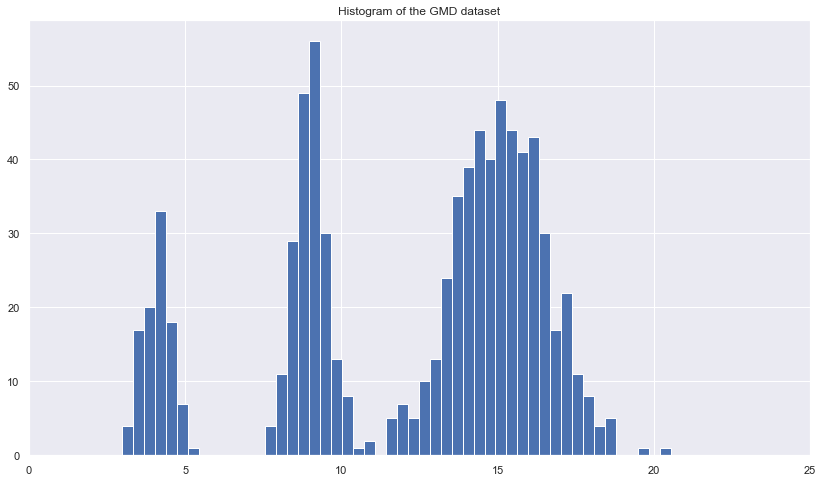

In [19]:
plt.hist(data, bins = 50)
plt.title('Histogram of the GMD dataset')
plt.xlim([0, 25])
plt.show()

<div class="alert alert-info">
    The expected value and variance for the data are:
    $$\mu = 12.199 \text{ and } \sigma = 17.569$$
    
Given the following equations:
    $$E(x) = \sum_{i=1}^k w_i E(X_i)$$
    $$Var(x) = \sum_{i=1}^k w_i E((X_i-\mu_i)^2)+\sum_{i=i}^k w_i(\mu_i-\mu)^2$$


And the fact that:
    $$
\sum_{i=1}^{k} w_i = 1
$$

We can substitute $w_3 = 1 - w_1 - w_2$ and get that $E(x) = \mu = w_1 \mu_1 + w_2 \mu_2 + (1 - w_1 - w_2) \mu_3$ or $E(x) = 12.199 = (w_1 * 4) + (.25 * 9) + (1 - .25 - w_1) \mu_3$ 
    
And $Var(X) = \sigma = (\sigma_1^2 * w_1) + (\sigma_2^2 * w_2) + (\sigma_3^2 * w_3) + w_1(\mu_1 - \mu)^2 + w_2(\mu_2 - \mu)^2 + w_3(\mu_3 - \mu)^2 $ or $Var(X) = 17.569 = (.5^2 * w_1) + (.5^2 * .25) + (1.5^2 * w_3) + w_1(4 - 12.199)^2 + .25(9 - 12.199)^2 + w_3(\mu_3 - 12.199)^2 $
    
Calculating this we get roughly:
    $$\mu_3 = 15.10$$ $$w_1 = .125$$ $$w_3 = .625$$
</div>

In [20]:
print(f"The data's mean is {data.mean()} and the data's variance is {data.var()}")

The data's mean is 12.19884308211053 and the data's variance is 17.569039044801865


<div class="alert alert-info">
    We solved mathematically using a system of equations, now we confirm in several ways:
    
    1. Use a python library called Sympy
    
    2. Do a naive check based on visualization
    
    3. Use Sklearn's Gaussian Mix
    
    4. Use the EM class we implemented
</div>

In [21]:
mu3, w1, w3 = symbols('mu3 w1 w3')

solution = solve([Eq(w1 * 4 + .25 * 9 + w3 * mu3, data.mean()),\
                  Eq((w1 * .5**2) + (.25 * .5**2) + (w3 * 1.5**2) + (w1 * (4 - data.mean())**2) + (.25 * (9 - data.mean())**2) + (w3 * (mu3 - data.mean())**2), data.var()),\
                  Eq(w1 + .25 + w3, 1)], [w1, w3, mu3])
print("Sympy calculations:")
print(f"w1: {solution[1][0]}, w3: {solution[1][1]}, mu3: {solution[1][2]}")

Sympy calculations:
w1: 0.123200492088126, w3: 0.626799507911874, mu3: 15.0862293195793


In [22]:
l = data[data < 6]
c = data[(7 < data) & (data < 11)]
r = data[11 < data]

print("Naive estimates:")
print(f"Curve 1: mean = {l.mean()}, standard deviation = {l.std()}, weight: {len(l) / len(data)}")
print(f"Curve 2: mean = {c.mean()}, standard deviation = {c.std()}, weight: {len(c) / len(data)}")
print(f"Curve 3: mean = {r.mean()}, standard deviation = {r.std()}, weight: {len(r) / len(data)}")

Naive estimates:
Curve 1: mean = 4.083810608397516, standard deviation = 0.46878881844482223, weight: 0.125
Curve 2: mean = 9.012985022621198, standard deviation = 0.5469250767143606, weight: 0.2525
Curve 3: mean = 15.120623353974276, standard deviation = 1.476653655067467, weight: 0.6225


In [23]:
print("Estimates from sklearn gaussian mix:")
gm = sklearn_gm(data, weights=weights, means=means)

Estimates from sklearn gaussian mix:
Curve 1: mean = 4.083810607997371, standard deviation = 0.46878988462323806, weight = 0.12499999995451154
Curve 2: mean = 8.997480255616866, standard deviation = 0.5250499740769304, weight = 0.25002262883598525
Curve 3: mean = 15.102615750104299, standard deviation = 1.501369524197505, weight = 0.6249773712095034


In [24]:
GMM = EM(k=3)
GMM.fit(data=data, means=means , stds=stds, weights=weights)
means_out, std_out, weights_out = GMM.get_dist_params()

In [25]:
print("Estimates from our custom EM class:")
GMM.print_vals()

Estimates from our custom EM class:
Curve 1: mean = 4.083810608063825, standard deviation = 0.46878881811171125, weight = 0.12499999996214464
Curve 2: mean = 8.998057873458702, standard deviation = 0.5257163034965265, weight = 0.2501328550458824
Curve 3: mean = 15.103461473593837, standard deviation = 1.500141756420795, weight = 0.624867144991973


#### 3.B
Plot a graph of the pdf of the distribution you inferred. Select adequate limits for the axes for this plot and explain your decision.

In [26]:
x_axis = np.arange(0, 22, 0.001)

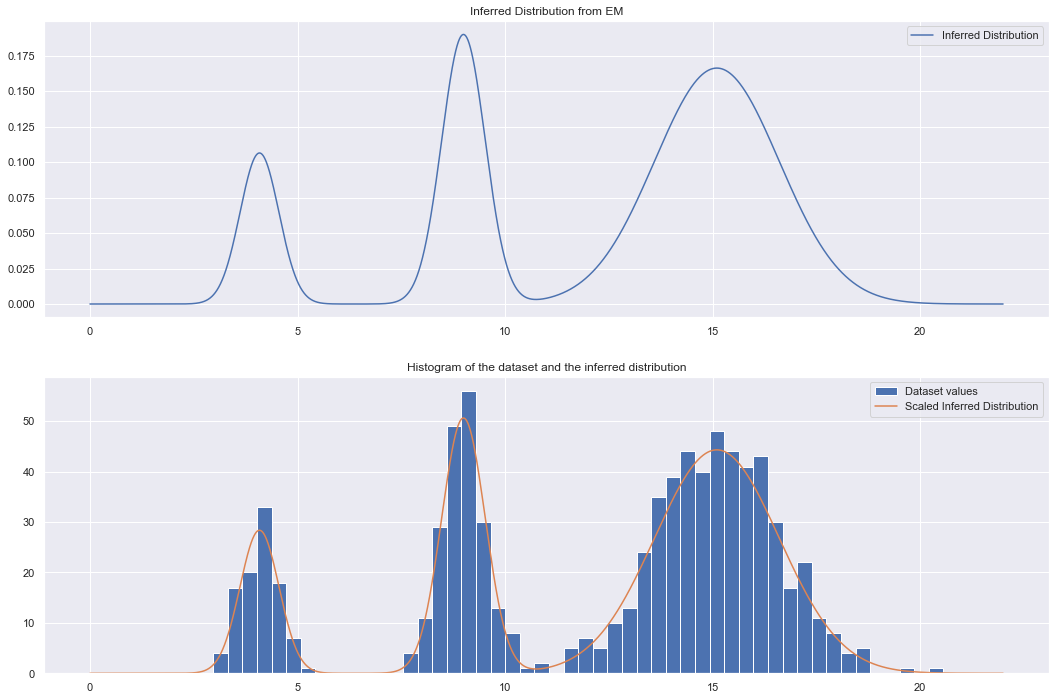

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
ax1.plot(x_axis, sum(weights_out[i] * norm.pdf(x_axis, means_out[i], std_out[i]) for i in range(3)), label = "Inferred Distribution")
ax1.set_title('Inferred Distribution from EM')
ax1.legend()
ax2.hist(data, bins = 50, label= "Dataset values")
ax2.plot(x_axis, len(data) / 3 * sum(weights_out[i] * norm.pdf(x_axis, means_out[i], std_out[i]) for i in range(3)), label = "Scaled Inferred Distribution")
ax2.set_title('Histogram of the dataset and the inferred distribution')
ax2.legend();


#### 3.C
Now assume that the data comes from a Gaussian mixture distribution (GMD) with $k=4$.

The given data and parameters stay the same.

Can you estimate the unknown parameters in the two ways described in section A? Explain.

<div class="alert alert-info">
We know there are three distinct curves in the data. Introducing a fourth peak would result in overfitting and will probably lead to a poorly performing model. One approach attempted to differentiate the three curves naively through visualization and generalization by explicitly acknowledging the presence of only three curves. However, this method is not viable as it is not possible to arbitrarily create a fourth curve this way. Another method, expectation-maximization (EM) would also yield poor results, as it is likely to split the rightmost curve into two symmetrical curves. Calculating it manually in a system of equations will depend on which values are unknown to us.
</div>

#### 3.D
Describe two ways for generating data for a GMM random variable with:
* centers at  $\mu_1=3, \mu_2=7, \mu_3=10$
* $\sigma_1=\sigma_2=\sigma_3=1$
* $w_1=w_2=w_3=0.33$

<div class="alert alert-info">
One way to generate data for a GMM random variable with the specified parameters is through direct sampling. This involves randomly selecting one of the three centers ($\mu_1, \mu_2,$ or $\mu_3$) with equal probability (since $w_1=w_2=w_3=0.33$) and then sampling a value from a normal distribution with the corresponding mean and standard deviation ($\sigma_1=\sigma_2=\sigma_3=1$). This process can be repeated multiple times to generate a desired number of data points.

Another way to generate data for a GMM random variable is through inverse sampling. This involves first sampling from a categorical distribution with three categories, each corresponding to one of the centers ($\mu_1, \mu_2$, or $\mu_3$), with probabilities $w_1, w_2$, and $w_3$. Then, a value can be sampled from a normal distribution with the corresponding mean and standard deviation ($\sigma_1=\sigma_2=\sigma_3=1$). As with direct sampling, this process can be repeated to generate a desired number of data points.
    </div>

#### 3.E
Use one of the above approaches to generate 1000 points and plot a histogram of the result (decide on bins, axes etc)


In [28]:
np.random.seed(100) 
x_axis = np.arange(0, 16, 0.001)
n = 1000
k = 3
means = [3, 7, 10]
std = [1, 1, 1]
weights = [0.33, 0.33, 0.33]

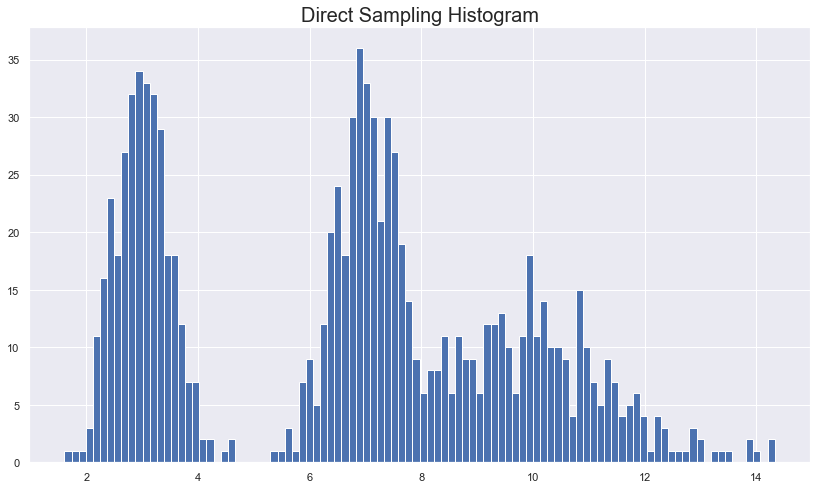

In [29]:
plt.hist(np.concatenate([np.random.normal(loc=means[i], scale=stds[i], size=round(n * weights[i])) for i in range(k)]) , bins=100)
plt.title('Direct Sampling Histogram', fontsize=20)
plt.show()

#### 3.F
Use the other one to generate 1000 more points and draw two comparative histograms.

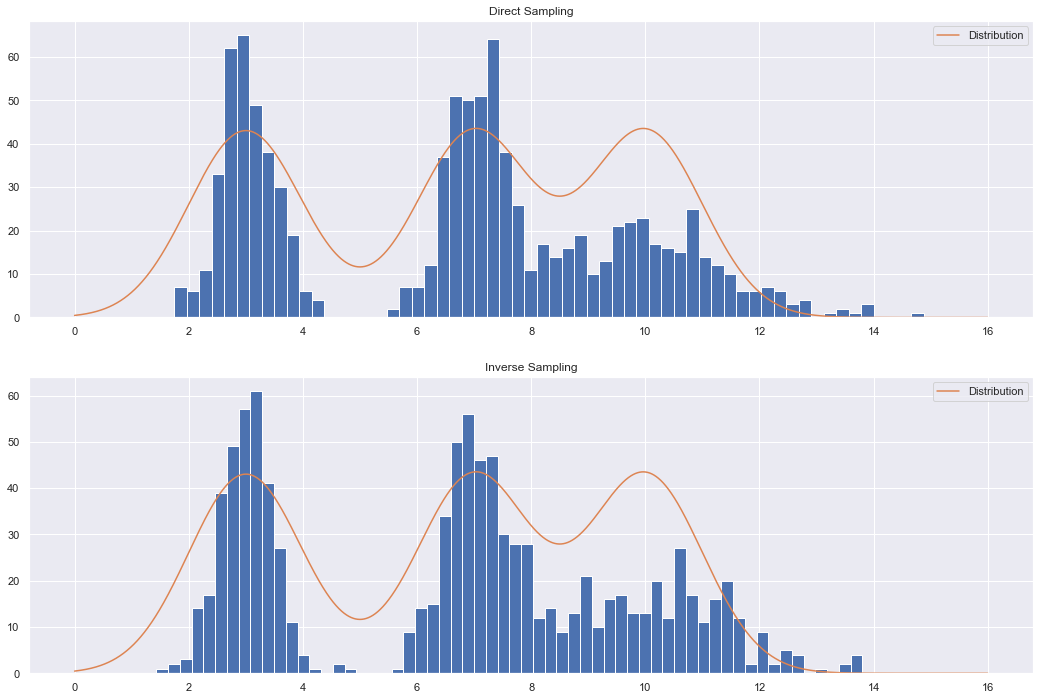

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].hist(np.concatenate([np.random.normal(loc=means[i], scale=stds[i], size=round(n * weights[i])) for i in range(k)]), bins=60)
ax[0].plot(x_axis,  
           sum(weights[i]**2 * len(np.concatenate([np.random.normal(loc=means[i], scale=stds[i], size=round(n * weights[i])) for i in range(k)])) * 
               norm.pdf(x_axis,means[i],std[i]) for i in range(k)), label = "Distribution")
ax[0].set_title('Direct Sampling')
ax[0].legend()
ax[1].hist(np.concatenate([norm.ppf(np.random.rand(round(n * weights[i])), loc=means[i], scale=stds[i]) for i in range(k)]), bins=60)
ax[1].plot(x_axis,  sum(weights[i]**2 * len(np.concatenate([norm.ppf(np.random.rand(round(n * weights[i])), loc=means[i], scale=stds[i]) for i in range(k)])) * norm.pdf(x_axis,means[i],std[i]) for i in range(k)), label = "Distribution")
ax[1].set_title('Inverse Sampling')
ax[1].legend()
plt.show()

### Question 4 - Normally distributed salaries

The annual salaries of employees in a large Randomistan company are approximateley normally distributed with a mean of 75,000 RCU and a standard deviation of 37,500 RCU.

In [31]:
mean = 75000
std = 37500

#### 4.A
What percent of people earn less than 50,000 RCU?

In [32]:
print(f'{round(norm.cdf(50000, loc=mean, scale=std) * 100, 3)}% of employees have an anual salary of less than 50,000 RCU')

25.249% of employees have an anual salary of less than 50,000 RCU


#### 4.B
What percent of people earn between 45,000 RCU and 65,000 RCU?

In [33]:
print(f'{round((norm.cdf(65000, loc=mean, scale=std) - norm.cdf(45000, loc=mean, scale=std)) * 100, 3)}% of employees have an anual salary between 45,000 and 65,000 RCU')

18.301% of employees have an anual salary between 45,000 and 65,000 RCU


#### 4.C
What percent of people earn more than 85,000 RCU?

In [34]:
print(f'{round((1 - norm.cdf(85000, loc=mean, scale=std)) * 100, 3)}% of employees have an anual salary of more than 85,000 RCU')

39.486% of employees have an anual salary of more than 85,000 RCU


#### 4.D
The company has 1000 employees. How many employees in the company do you expect to earn more than 140,000 RCU?

In [35]:
print(f'We expect to find {round(1000 * (1 - norm.cdf(140000, loc=mean, scale=std)), 3)} employees with an anual salary of more than 140000 RCU')

We expect to find 41.518 employees with an anual salary of more than 140000 RCU


### Question 5 - Coupon collector

Let $T_{N}$ denote the waiting time for full single coupon collection with N different equiprobable coupon types

In [36]:
class CouponCollector:
    def __init__(self, n: int):
        self.n = n
        self.p = (n - np.arange(n)) / n  
        self.mean = sum(1/ self.p)
        self.var = sum((1 - self.p)/(self.p * self.p))
        self.std = np.sqrt(self.var)

    def cdf(self, k: int, N=None):
        """k - the number of trials. We are computing the CDF probability P(X<=k),
               where variable X represents the number of trials until N coupons are collected.
           N - the number of coupons we want to collect (i.e. this parameter specifies what variable 
               X actually represents. For instance if N=1, then X is the number of trials we need
               to perform in order to get *one* coupon, and if N=2, then X represents the number of trials
               we perfrom until we get just 2 distinct coupons. By default N is the total number of
               available coupons, self.n
        """
        if N is None: N=self.n
        convolve = geom.pmf(np.arange(1, k + 1), self.p[0])
        for p in self.p[1:(N+1)]:
            convolve = np.convolve(convolve, geom.pmf(np.arange(1, k + 1), p))
        return sum(convolve[:int(k + 1 - N)])

In [37]:
def markov_coupons(coupons, unique_coupons, trials):
    matrix = np.zeros((coupons + 1, coupons + 1))
    
    for i in range(0, coupons + 1):
        matrix[i,i] = 1 - (coupons - i) / coupons
        if i < coupons: matrix[i,i+1] = (coupons - i) / coupons
    
    final_state = np.matmul(np.array([1]+[0 for i in range(coupons)]), np.linalg.matrix_power(matrix, trials))
    return sum(final_state[0:unique_coupons])

#### 5.A
Write code to compute the exact value of $E(T_{N})$

<div class="alert alert-info">
    $$E(T_N) = \sum_{i=1}^N E(X_i) = N \sum_{i=1}^N \frac{1}{i}$$
</div>

In [38]:
CouponCollector(100).mean

518.737751763962

#### 5.B
Write code to compute the exact value of $V(T_{N})$

<div class="alert alert-info">
$$
V(T_N) = V(\sum_{i=1}^N X_i) = \sum_{i=1}^N V(X_i)
$$
    </div>

In [39]:
CouponCollector(100).var

15831.101250084967

#### 5.C
Write code to exactly compute $P(T_{30}>60)$

In [40]:
1 - CouponCollector(30).cdf(60)

0.9940158432042814

In [41]:
markov_coupons(30, 30, 60)

0.994015843204282

#### 5.D
Let $S_N$ denote the waiting time until $N/2$ different coupons are collected.

Write code to exactly compute $P(S_{30}>60)$

<div class="alert alert-info">
The problem involves collecting coupons from a number of coupon options, with the goal of collecting some distinct coupons after a certain number of trials. The probability of collecting a new coupon at each draw is given by $p_i = \frac{N - i + 1}{N}$, where $N$ is the total number of coupons and $i$ is the number of unique coupons collected so far.

We can represent the state of the system at a given time $i$ as a vector $\overrightarrow{C^{i}}^{T}$, where the $j^{th}$ entry, $c_j$, represents the probability of having collected $j$ unique coupons at time $i$. The initial state of the system, $\overrightarrow{C^{0}}^{T}$, has a single non-zero entry at index 0, representing the probability of having collected 0 unique coupons at the start.
    $$  \begin{align}
    \overrightarrow{C^{i}}^{T} &= \begin{bmatrix}
           c_{1} \\
           c_{2} \\
           \vdots \\
           c_{31}
         \end{bmatrix}
  \end{align}$$

The behavior of the system is probability of collecting a certain number of unique coupons at time $t+s$ given that we have collected at least $t$ unique coupons at time $t$ is equal to the probability of collecting that number of unique coupons at time $s$. This allows us to describe the system using a Markov chain, with the transition matrix $T$ given by:

$$  \begin{align}
        T &=\begin{bmatrix}
        1-p_{1}       & p_{1} & 0 & \dots & 0 \\
        0       & 1-p_{2} & p_{2} & \dots & 0 \\
        \vdots & \vdots & \vdots & \dots & \vdots \\
        0       & 0 & 0 & \dots & 1
    \end{bmatrix}
\end{align}$$

where $p_i = \frac{N - i + 1}{N}$.

To find the probability of not collecting all unique_coupons distinct coupons after trials draws, we can raise the transition matrix to the trials power, $T^{trials}$, and take the dot product with the initial state vector, $\overrightarrow{C^{0}}^{T}$. The resulting final state vector, $\overrightarrow{C^{trials}}^{T}$, gives the probabilities of collecting each possible number of unique coupons after trials draws. We can then sum the probabilities of collecting 0 to unique_coupons - 1 unique coupons to find the desired probability.
    </div>

In [42]:
markov_coupons(30, 15, 60)

1.7143091976502042e-12